# Identifying Painters Using Machine Learning

Creator: Jurjan Bootsma

## 1. Introduction

Art is one of the greatest achievements of humankind, symbolizing culture, communication and creativity. Painters have captured the imagination of generations throughout history. Art reinvented itself in the form of many different styles, with every painter adding its own unique touch. Until the past decade, art historians and experts were always essential for identifying painters from their work with high certianty. However, the current machine learning revolution enables for the first time ever to use computers to recognize patterns and styles of specific artists [1].

In the previous decade, some groundbreaking methods were implemented to convolutional neural networks (CNNs), enabling them to consist of many deep layers. As a result, algorithms suddenly became capable of analyzing images at or beyond human level. This breakthrough led to numerous applications in science and technology [2]. The field of art provides an exciting playground for the development of new deep CNNs. However, more importantly, these models could assist art historians to reaching new insights in the styles of painters or help discriminate between authentic or fake paintings [3][4].

This analysis aims to test different architectures of CNNs and their parameters. It examines a dataset containing images of the paintings of 50 of the best painters of all time. The primary objective is to develop a classification model capable of analyzing the visual features of the paintings and predicting the artist. Additionally, the analysis seeks to understand the model's details and identify its shortcomings.

In section 2, the data is described and the preprocessing steps are explained; in section 3, the machine learning methods are eloborated and their selection is analyzed; in section 4, the results are shared; in section 5, those results are discussed; in section 6, the findings are summarized and concluded.

## 2. Data description

The data consists of a collection of the 50 most influential artists of all time. This has been retrieved from the "Best artworks of all time" dataset on Kaggle, which can be found using the link underneath [5].
<br> <br>
https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time
<br> <br>
This dataset consists of 3 components:
<br>
1. artists.csv
<br>
A csv file containing the names of all 50 painters with additional information. Next to the names, information can be found such as IDs, years in which they lived, the style is which they painted, their nationality, a biography, a link to their wikipedia page and the number of paintings they created.
<br>
2. images.zip
<br>
A zip file containing subdirectories of 50 painters, which contains all the paintings in .jpg form of the respective artist.
<br>
3. resized.zip
<br>
Again a zip file with the paintings as .jpg, but without the subdirectories. This part of the data will be ignored during this analysis.

We start here with some exploratory data analysis.

In [1]:
# Import all libraries that are needed for the analysis
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import pandas as pd
import os
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import shutil

# Torch functions
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Torchvision functions
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

**Exploring the artists in general**

To illustrate the information stored within the artists.csv file, we show here the first 5 painters in the file displayed with their information.

In [2]:
artists = pd.read_csv('archive/artists.csv')
artists.head(5) # Only show first 5 rows

id                name        years                         genre   
0   0   Amedeo Modigliani  1884 - 1920                 Expressionism  \
1   1  Vasiliy Kandinskiy  1866 - 1944  Expressionism,Abstractionism   
2   2        Diego Rivera  1886 - 1957       Social Realism,Muralism   
3   3        Claude Monet  1840 - 1926                 Impressionism   
4   4       Rene Magritte  1898 - 1967      Surrealism,Impressionism   

  nationality                                                bio   
0     Italian  Amedeo Clemente Modigliani (Italian pronunciat...  \
1     Russian  Wassily Wassilyevich Kandinsky (Russian: Васи́...   
2     Mexican  Diego María de la Concepción Juan Nepomuceno E...   
3      French  Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...   
4     Belgian  René François Ghislain Magritte (French: [ʁəne...   

                                        wikipedia  paintings  
0  http://en.wikipedia.org/wiki/Amedeo_Modigliani        193  
1  http://en.wikipedia.org/wiki/Wassily_Kandinsky         88  
2       http://en.wikipedia.org/wiki/Diego_Rivera         70  
3       http://en.wikipedia.org/wiki/Claude_Monet         73  
4      http://en.wikipedia.org/wiki/René_Magritte        194

For the scope of this analysis, we are only interested in classifying all of the paintings with their painter. Furthermore, we want to sort the dataset to the number of paintings created. For this reason, we sort the dataset and drop all of the other columns. Finally, we show the number of paintings per painter.

In [3]:
artists_by_paintings = artists[['name', 'paintings']].sort_values(by=['paintings'], ascending=False)
print(artists_by_paintings)

                         name  paintings
8            Vincent van Gogh        877
30                Edgar Degas        702
13              Pablo Picasso        439
15      Pierre-Auguste Renoir        336
19             Albrecht Dürer        328
46               Paul Gauguin        311
16             Francisco Goya        291
31                  Rembrandt        262
20              Alfred Sisley        259
32                     Titian        255
22               Marc Chagall        239
4               Rene Magritte        194
0           Amedeo Modigliani        193
42                  Paul Klee        188
28              Henri Matisse        186
45                Andy Warhol        181
12             Mikhail Vrubel        171
24          Sandro Botticelli        164
26          Leonardo da Vinci        143
14          Peter Paul Rubens        141
5               Salvador Dali        139
10           Hieronymus Bosch        137
21             Pieter Bruegel        134
27            Di

The above list of paintings reveals that a lot of the painters did not create many paintings during their lifetime. Since we do need a significant amount of paintings to train the model properly, we decided to only look at the 10 painters that created the most paintings (more than 250).

In [4]:
artists_selection = artists_by_paintings[:10].reset_index() # Choose only top 10 painters who created the most
print(artists_selection)

   index                   name  paintings
0      8       Vincent van Gogh        877
1     30            Edgar Degas        702
2     13          Pablo Picasso        439
3     15  Pierre-Auguste Renoir        336
4     19         Albrecht Dürer        328
5     46           Paul Gauguin        311
6     16         Francisco Goya        291
7     31              Rembrandt        262
8     20          Alfred Sisley        259
9     32                 Titian        255


This dataset is very unbalanced, since for example Vincent can Gogh created more than 3 times as much paintings as Titian. If we train our model to these paintings, it might "guess" Vincent van Gogh every time, without really learning anything about the data. For this reason, we assigned weights to every painter, something that can be used later to balance the dataset.

In [6]:
artists_selection['weight'] = artists_selection.paintings.sum() / (artists_selection.shape[0] * artists_selection.paintings)
print(artists_selection)

   index                   name  paintings    weight
0      8       Vincent van Gogh        877  0.462942
1     30            Edgar Degas        702  0.578348
2     13          Pablo Picasso        439  0.924829
3     15  Pierre-Auguste Renoir        336  1.208333
4     19         Albrecht Dürer        328  1.237805
5     46           Paul Gauguin        311  1.305466
6     16         Francisco Goya        291  1.395189
7     31              Rembrandt        262  1.549618
8     20          Alfred Sisley        259  1.567568
9     32                 Titian        255  1.592157


Because later on torch will sort all the directories alphabetically, we also sort our dataframe alphabetically, so we can use the information later properly.

In [12]:
artists_alphabet = artists_selection.sort_values(by='name')
print(artists_alphabet)

   index                   name  paintings    weight
4     19         Albrecht Dürer        328  1.237805
8     20          Alfred Sisley        259  1.567568
1     30            Edgar Degas        702  0.578348
6     16         Francisco Goya        291  1.395189
2     13          Pablo Picasso        439  0.924829
5     46           Paul Gauguin        311  1.305466
3     15  Pierre-Auguste Renoir        336  1.208333
7     31              Rembrandt        262  1.549618
9     32                 Titian        255  1.592157
0      8       Vincent van Gogh        877  0.462942


**Having a look at some of the paintings**

The painters are now properly selected and ordered. We now move the focus to the paintings and explore some of them to get an intuitive idea of the dataset. We start by creating a new subdirectory with only the paintings of the 10 painters we are considering in this analysis.

In [7]:
# Create destination directory if it doesn't exist

images_dir_all = './archive/images/images/'
images_dir = './archive/images_selection/'
artists_dir = artists_selection['name'].str.replace(' ', '_').values

if not os.path.exists(images_dir):
    os.makedirs(images_dir)

    # Copy directories if they don't already exist in the destination
    for artist_subdir in artists_dir:
        src_path = os.path.join(images_dir_all, artist_subdir)
        dest_path = os.path.join(images_dir, artist_subdir)
        if not os.path.exists(dest_path):
            if os.path.exists(src_path):
                shutil.copytree(src_path, dest_path)
            else:
                print(f"Source directory {src_path} does not exist")
        else:
            print(f"{dir_name} already exists in {images_dir}, skipping")
else:
    print("The directory with the 10 best painters already exists.")

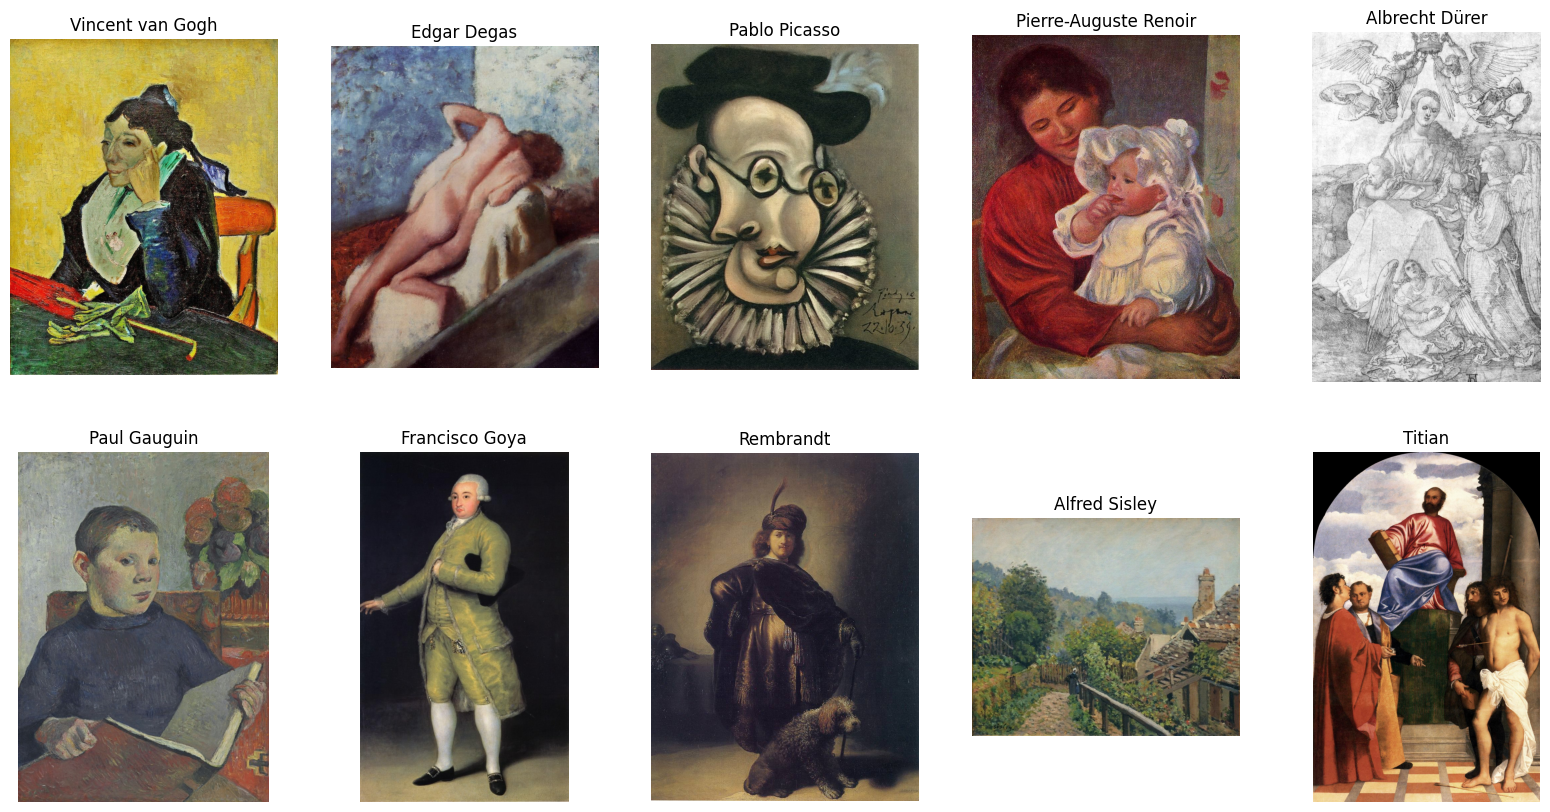

In [8]:
# Print 1 painting per painter
n=10
fig, axes = plt.subplots(2, 5, figsize=(20,10))

# Loop over all 10 painters
for i in range(n):
    image = os.listdir(os.path.join(images_dir, artists_dir[i]))[2]
    image_file = os.path.join(images_dir, artists_dir[i], image)
    image_plot = plt.imread(image_file)
    axes[i//5, i%5].imshow(image_plot)
    axes[i//5, i%5].set_title(artists_dir[i].replace('_', ' '))
    axes[i//5, i%5].axis('off')

plt.show()

By eye, we can already see many differences in style. We can see that some painters make use of dramatic light-dark contrast, while other painters use brighter colours. This is only 1 of the many differences in style of the painters. These are exactly the type of characteristics convolutional layers could exploit to create the optimal fit.

Now we have a look at 10 paintings of Vincent van Gogh.

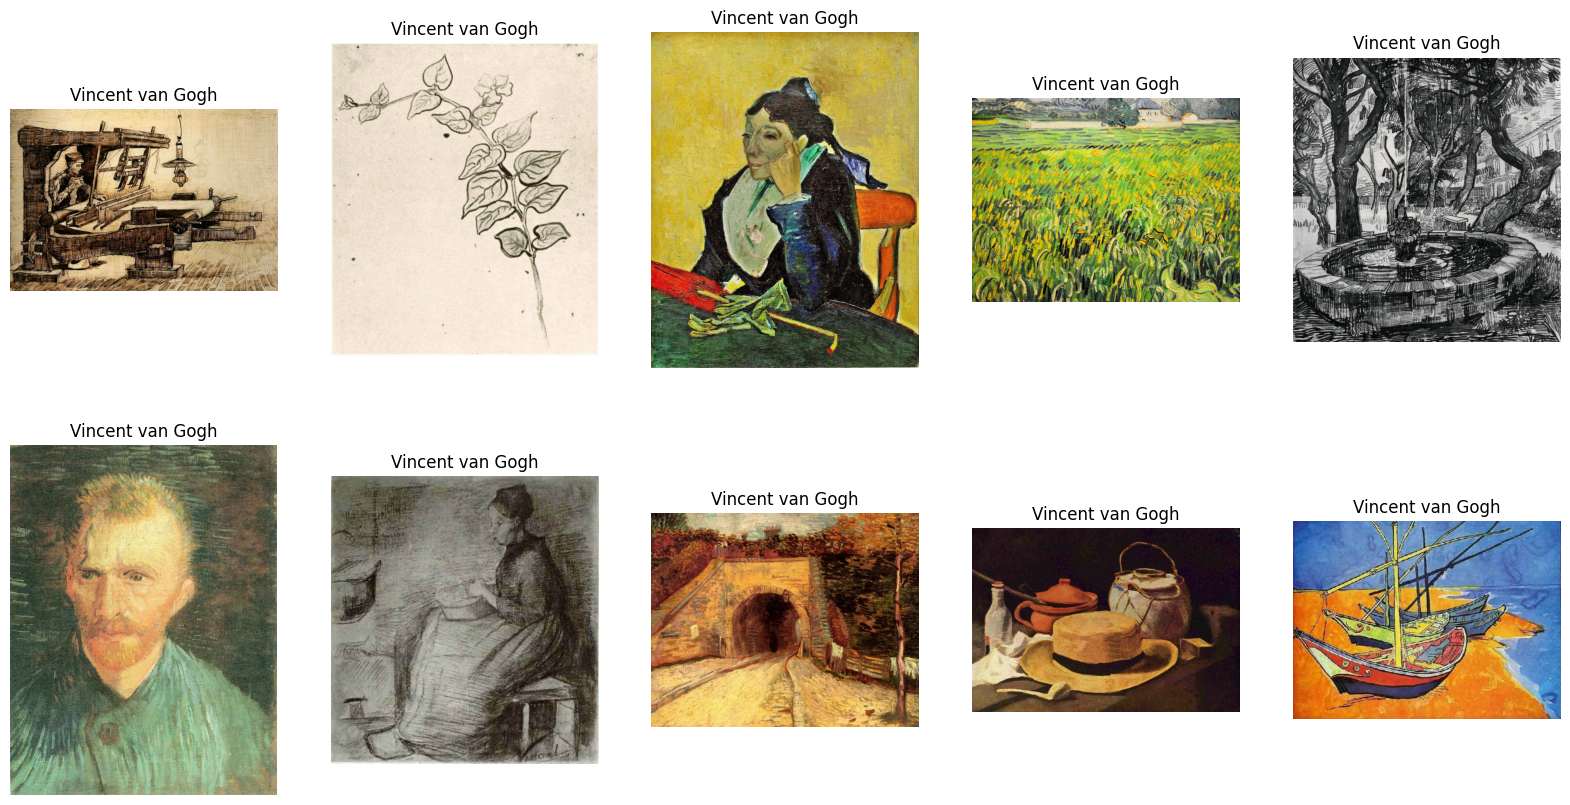

In [9]:
# Print 10 van Goghs
n=10
fig, axes = plt.subplots(2, 5, figsize=(20,10))

# Loop over 10 paintings
for i in range(n):
    image = os.listdir(os.path.join(images_dir, artists_dir[0]))[i]
    image_file = os.path.join(images_dir, artists_dir[0], image)
    image_plot = plt.imread(image_file)
    axes[i//5, i%5].imshow(image_plot)
    axes[i//5, i%5].set_title(artists_dir[0].replace('_', ' '))
    axes[i//5, i%5].axis('off')

plt.show()

Here we can already see something that could be hard for the machine learning algorithm. There is a lot of variation within the collection of paintings. Some paintings do use a lot of colours, while others do not even have colour at all. Some show people, other just objects. This is something that might be challenging to handle for the CNN.

**Data preprocessing**

Now we will do some data preprocessing, so that the data can be used efficiently in the CNNs. The images will be resized to a size of 130 x 130. Furhermore, the pixel values are normalized to a mean of 0.5 with a standard deviation of also 0.5, to make the fitting more efficient. The images will be split in 3 channels, corresponding to the 3 different colours. Also, the data will be split in an 80% training set and 20% testing set. Finally, the data will be made balanced. We use the previously calculated weights, and put that in a random sampler for the training data. This way the training data will consist of 10% paintings of each artist.

In [10]:
random_seed = 333
torch.manual_seed(random_seed)

In [13]:
# Define transforms for the images
data_transform = transforms.Compose([
    transforms.Resize((130, 130)),  # Resize images to the size 224x224
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

#images_dir = 'archive/images_selection/'
#images_dir = 'drive/MyDrive/Colab Notebooks/archive_ten/images/images'

# Load the dataset
dataset = ImageFolder(root=images_dir, transform=data_transform)

train_size = int(0.8 * len(dataset))  # 80% training data
test_size = len(dataset) - train_size  # 20% test data

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Calculate class weights

n_paintings = (artists_selection.sort_values(by=['name']))['paintings'].values
weights_painters = torch.Tensor(artists_alphabet['weight'].values)
weights_paintings = ([[weights_painters[label]] for _, label in train_dataset])

weights = torch.Tensor(weights_paintings)[:,0]
sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights))

# Define batch size
batch_size = 32
# Create DataLoader
train_loader = DataLoader(train_dataset, sampler=sampler, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)  # No sampler needed for test set

In [14]:
examples = list(test_loader) # Create some examples for displaying
example_data, example_targets = examples[0]

Underneath 1 painting is shown once more, but now normalized and seperated in the 3 different colours. This form will be the input of the model.

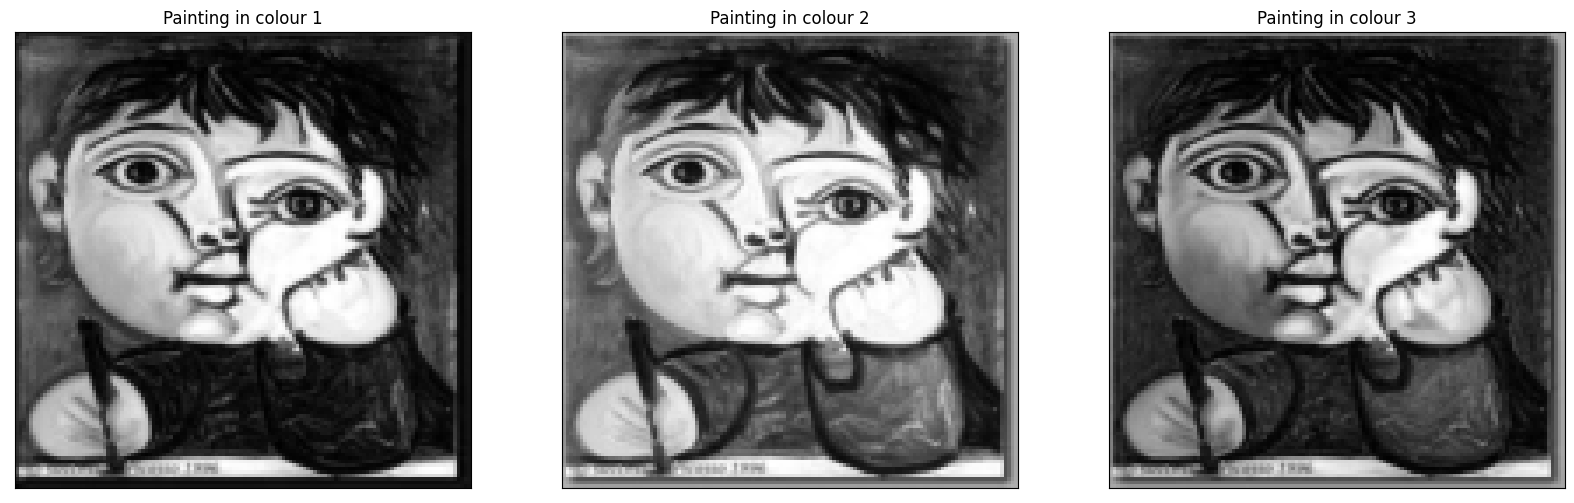

In [15]:
n=3
fig, axs = plt.subplots(1, n, figsize=(20,10))
for i in range(n):
    #axs[i].tight_layout()
    axs[i].imshow(example_data[0][i], cmap='gray', interpolation='none')
    axs[i].set_title(f"Painting in colour {i+1}")
    axs[i].set_xticks([])
    axs[i].set_yticks([])

## 3. Methodology

Now that our data is ready to use, we discuss the methods that are used to analyze the paintings. The analysis makes use of Convolutional Neural Networks (CNNs), as these work very well for complex machine learning tasks, such as image classification. We did not use pre-trained CNNs from other libraries, but created the architectures from scratch. The analysis focuses on a few different aspects. First of all, different learning rates are compared with the loss rate. From this, the optimal learning rate can be selected to perform the rest of the analysis on. Secondly, different CNNs are fitted and compared. The best model will be used to analyze the results. Finally, the results are visualized.

**The convolutional neural networks**

In this subsection, the 4 CNNs are defined. They all have 2 linear layers, but the number of convolutional layers range between 1 and 4. In the results section, they will all be ran and compared and the model that produces the best accuracy will be chosen to analyze the results.

In [16]:
# CNN with 3 trainable layers. First 1 convolutional and then 2 linear.
class PaintNet3(nn.Module):
    def __init__(self):
        super(PaintNet3, self).__init__()
        # Functions that will be used
        self.conv1 = nn.Conv2d(3,16,(3,3))
        self.linear1 = nn.Linear(65536, 1000)
        self.linear2 = nn.Linear(1000,10)

    def forward(self, x):
        # The actual neural net
        N = x.shape[0]
        x = self.conv1(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = torch.reshape(x, (N,65536))
        x = F.relu(self.linear1(x))
        x = F.softmax(self.linear2(x), dim=1)
        return x

In [17]:
# CNN with 4 trainable layers. First 2 convolutional and then 2 linear.
class PaintNet4(nn.Module):
    def __init__(self):
        super(PaintNet4, self).__init__()
        # Functions that will be used
        self.conv1 = nn.Conv2d(3,16,(3,3))
        self.conv2 = nn.Conv2d(16,32,(5,5), padding=2)
        self.linear1 = nn.Linear(32768, 1000)
        self.linear2 = nn.Linear(1000,10)

    def forward(self, x):
        # The actual neural net
        N = x.shape[0]
        x = self.conv1(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = self.conv2(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = torch.reshape(x, (N,32768))
        x = F.relu(self.linear1(x))
        x = F.softmax(self.linear2(x), dim=1)
        return x

In [18]:
# CNN with 5 trainable layers. First 3 convolutional and then 2 linear.
class PaintNet5(nn.Module):
    def __init__(self):
        super(PaintNet5, self).__init__()
        # Functions that will be used
        self.conv1 = nn.Conv2d(3,16,(3,3))
        self.conv2 = nn.Conv2d(16,32,(5,5), padding=2)
        self.conv3 = nn.Conv2d(32,64,(3,3), padding=1)
        self.linear1 = nn.Linear(16384, 1000)
        self.linear2 = nn.Linear(1000,10)

    def forward(self, x):
        # The actual neural net
        N = x.shape[0]
        x = self.conv1(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = self.conv2(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = self.conv3(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = torch.reshape(x, (N,16384))
        x = F.relu(self.linear1(x))
        x = F.softmax(self.linear2(x), dim=1)
        return x

In [19]:
# CNN with 6 trainable layers. First 4 convolutional and then 2 linear.
class PaintNet6(nn.Module):
    def __init__(self):
        super(PaintNet6, self).__init__()
        # Functions that will be used
        self.conv1 = nn.Conv2d(3,16,(3,3), padding=1)
        self.conv2 = nn.Conv2d(16,32,(3,3), padding=1)
        self.conv3 = nn.Conv2d(32,64,(3,3), padding=1)
        self.conv4 = nn.Conv2d(64,128,(3,3), padding=1)
        self.linear1 = nn.Linear(8192, 1000)
        self.linear2 = nn.Linear(1000, 10)

    def forward(self, x):
        # The actual neural net
        N = x.shape[0]
        x = self.conv1(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = self.conv2(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = self.conv3(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = self.conv4(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = torch.reshape(x, (N,8192))
        x = F.relu(self.linear1(x))
        x = F.softmax(self.linear2(x), dim=1)
        return x

**Training tools**

Functions are defined to enable the training and the testing in an efficient way.

In [20]:
# Use GPU
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

In [21]:
# This is the main training loop
log_interval = 10

# Function that trains and updates the network
def train(epoch, network):
    train_count = []
    train_loss = []
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(DEVICE)
        target = target.to(DEVICE)
        output = network(data)
        loss = F.cross_entropy(output, target) # The loss function
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_loss.append(loss.item())
            train_count.append(
                (batch_idx*batch_size) + ((epoch-1)*len(train_loader.dataset)))
    return train_count, train_loss, network

# This is the main testing loop
def test(network):
    network.eval()
    test_loss = 0
    correct = 0
    test_loss_arr = []
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(DEVICE)
            target = target.to(DEVICE)
            output = network(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            #print(target, pred)
    test_loss /= len(test_loader.dataset)
    test_loss_arr.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss_arr

In [22]:
def model_fit(network, learning_rate, n_epochs):
    optimizer = optim.Adam(network.parameters(), lr=learning_rate)
    # Define empty lists
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

    # Start the train/test
    test_loss = test(network)
    test_losses.extend(test_loss)
    for epoch in range(1, n_epochs + 1):
        train_count, train_loss, network = train(epoch, network)
        train_counter.extend(train_count)
        train_losses.extend(train_loss)

        test_loss = test(network)
        test_losses.extend(test_loss)



    return train_counter, train_losses, test_counter, test_losses, network


**Visualizing the results**

When the best model with the optimal learning rate is selected and trained, the results will be visualized. First, some example paintings will be shown with their actual and guessed painters, to get a more intuitive feeling of the model's performance. Additional to the total accuracy, the seperate accuracies per painter will be shown. Finally, a confusion matrix is constructed, so that interesting patterns between the guessing of painters can be seen.

## 4. Results

In this section, we trained the models and evaluated the results. We start by finding the optimal learning rate, by doing a grid search. After this, we used the optimal learning rate to train the model. After the model is trained, we show its results in the form of its loss rate evolution, the final accuracy and some examples of the predictions.

**Finding the optimal learning rate**

We start with finding the optimal learning rate. This grid search is done by looking at 7 logarithmically seperated learning rates in the range $10^{-5}$ to $10^{-2}$, each trained for 10 epochs. Than the average loss rate of the final epoch is taken and compared to the others.

In [24]:
learning_rates = np.logspace(-5,-2,7) # The learning rates to try

# Create empty lists which will hold all losses and number of training examples seen
train_loss_lr = []
train_counter_lr = []
test_loss_lr = []
test_counter_lr = []

n_epochs = 10
for learning_rate in learning_rates: # Loop over the different learning rates.
    network = PaintNet4().to(DEVICE)  # Define new network every time in the loop
    optimizer = optim.Adam(network.parameters(), lr=learning_rate) # Define new optimizer with new learning rate

    train_counter, train_losses, test_counter, test_losses, network = model_fit(network, learning_rate, n_epochs)
    train_loss_lr.append(train_losses)
    train_counter_lr.append(train_counter)
    test_loss_lr.append(test_losses)
    test_counter_lr.append(test_counter)

train_counter_lr_arr = np.array([train_counter_lr])
train_loss_lr_arr = np.array([train_loss_lr])
test_counter_lr_arr = np.array([test_counter_lr])
test_loss_lr_arr = np.array([test_loss_lr])


Test set: Avg. loss: 2.3028, Accuracy: 55/812 (7%)

Train Epoch: 1 [0/3248 (0%)]	Loss: 2.302985
Train Epoch: 1 [320/3248 (10%)]	Loss: 2.296592
Train Epoch: 1 [640/3248 (20%)]	Loss: 2.281557
Train Epoch: 1 [960/3248 (29%)]	Loss: 2.270246
Train Epoch: 1 [1280/3248 (39%)]	Loss: 2.268545
Train Epoch: 1 [1600/3248 (49%)]	Loss: 2.229230
Train Epoch: 1 [1920/3248 (59%)]	Loss: 2.218803
Train Epoch: 1 [2240/3248 (69%)]	Loss: 2.186979
Train Epoch: 1 [2560/3248 (78%)]	Loss: 2.213948
Train Epoch: 1 [2880/3248 (88%)]	Loss: 2.244691
Train Epoch: 1 [3200/3248 (98%)]	Loss: 2.289270

Test set: Avg. loss: 2.2198, Accuracy: 167/812 (21%)

Train Epoch: 2 [0/3248 (0%)]	Loss: 2.186702
Train Epoch: 2 [320/3248 (10%)]	Loss: 2.255694
Train Epoch: 2 [640/3248 (20%)]	Loss: 2.148429
Train Epoch: 2 [960/3248 (29%)]	Loss: 2.087483
Train Epoch: 2 [1280/3248 (39%)]	Loss: 2.111022
Train Epoch: 2 [1600/3248 (49%)]	Loss: 2.106791
Train Epoch: 2 [1920/3248 (59%)]	Loss: 2.160488
Train Epoch: 2 [2240/3248 (69%)]	Loss: 2.1

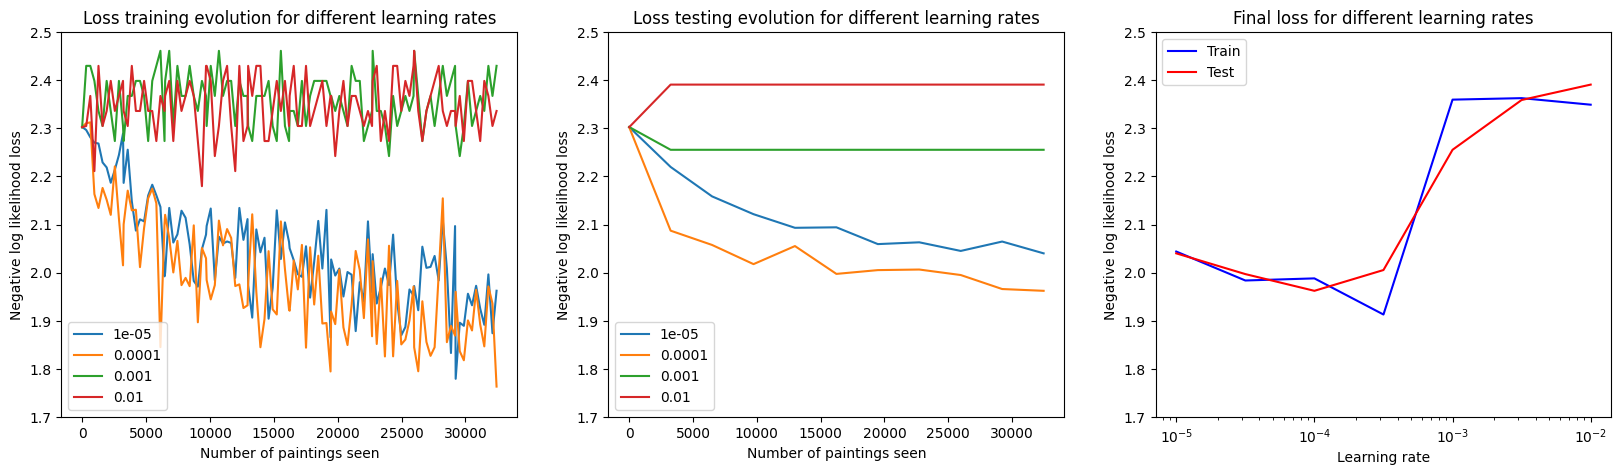

In [47]:
# Plot the average loss rate vs the learning rate, and look for the minimum.

fig, axs = plt.subplots(1,3,figsize=(20,5))

# Just plot the 10^-5, 10^-4, 10^-3, and 10^-2 to keep it clear
axs[0].plot(train_counter_lr[0],train_loss_lr[0], label='{:.0e}'.format(learning_rates[0]))
axs[0].plot(train_counter_lr[2],train_loss_lr[2], label=learning_rates[2])
axs[0].plot(train_counter_lr[4],train_loss_lr[4], label=learning_rates[4])
axs[0].plot(train_counter_lr[6],train_loss_lr[6], label=learning_rates[6])
axs[0].set_ylim(1.7, 2.5)
axs[0].set_xlabel("Number of paintings seen")
axs[0].set_ylabel("Negative log likelihood loss")
axs[0].set_title("Loss training evolution for different learning rates")
axs[0].legend()

axs[1].plot(test_counter_lr[0],test_loss_lr[0], label=learning_rates[0])
axs[1].plot(test_counter_lr[2],test_loss_lr[2], label=learning_rates[2])
axs[1].plot(test_counter_lr[4],test_loss_lr[4], label=learning_rates[4])
axs[1].plot(test_counter_lr[6],test_loss_lr[6], label=learning_rates[6])
axs[1].set_ylim(1.7, 2.5)
axs[1].set_xlabel("Number of paintings seen")
axs[1].set_ylabel("Negative log likelihood loss")
axs[1].set_title("Loss testing evolution for different learning rates")
axs[1].legend()

axs[2].plot(learning_rates, np.mean(train_loss_lr_arr[:,-20:],axis=2)[0], color='blue', label='Train') # Average training loss at the end
axs[2].plot(learning_rates, test_loss_lr_arr[0,:,-1], color='red', label='Test') # Average testing loss at the end
axs[2].set_ylim(1.7, 2.5)
axs[2].set_xscale('log')
axs[2].set_xlabel("Learning rate")
axs[2].set_ylabel("Negative log likelihood loss")
axs[2].set_title("Final loss for different learning rates")
axs[2].legend()
plt.show()

From the above figure, we can see that a too high learning rate (>$10^{-3}$) performs very bad, while too low ($10^{-5}$) is also not optimal. Although the lowest training loss is at $10^{-3.5}$, we can see that $10^{-4}$ gives the lowest testing loss. For this reason, we set the learning rate to this value for the remainder of this analysis.

In [48]:
learning_rate = 10**-4

**Trying different CNN architectures**

In [50]:
n_epochs = 15

networks_input = [PaintNet3().to(DEVICE), PaintNet4().to(DEVICE), PaintNet5().to(DEVICE), PaintNet6().to(DEVICE)]
networks_output = []
train_loss_nw = []
train_counter_nw = []
test_loss_nw = []
test_counter_nw = []

for network in networks_input:
    optimizer = optim.Adam(network.parameters(), lr=learning_rate)

    train_counter, train_losses, test_counter, test_losses, network = model_fit(network, learning_rate, n_epochs)

    networks_output.append(network)
    train_loss_nw.append(train_losses)
    train_counter_nw.append(train_counter)
    test_loss_nw.append(test_losses)
    test_counter_nw.append(test_counter)

train_counter_nw_arr = np.array([train_counter_nw])
train_loss_nw_arr = np.array([train_loss_nw])
test_counter_nw_arr = np.array([test_counter_nw])
test_loss_nw_arr = np.array([test_loss_nw])


Test set: Avg. loss: 2.3022, Accuracy: 111/812 (14%)

Train Epoch: 1 [0/3248 (0%)]	Loss: 2.303658
Train Epoch: 1 [320/3248 (10%)]	Loss: 2.190705
Train Epoch: 1 [640/3248 (20%)]	Loss: 2.188226
Train Epoch: 1 [960/3248 (29%)]	Loss: 2.126008
Train Epoch: 1 [1280/3248 (39%)]	Loss: 2.118150
Train Epoch: 1 [1600/3248 (49%)]	Loss: 1.987776
Train Epoch: 1 [1920/3248 (59%)]	Loss: 2.018101
Train Epoch: 1 [2240/3248 (69%)]	Loss: 2.207761
Train Epoch: 1 [2560/3248 (78%)]	Loss: 2.175159
Train Epoch: 1 [2880/3248 (88%)]	Loss: 2.123276
Train Epoch: 1 [3200/3248 (98%)]	Loss: 2.073898

Test set: Avg. loss: 2.1786, Accuracy: 215/812 (26%)

Train Epoch: 2 [0/3248 (0%)]	Loss: 2.164095
Train Epoch: 2 [320/3248 (10%)]	Loss: 2.061006
Train Epoch: 2 [640/3248 (20%)]	Loss: 2.101128
Train Epoch: 2 [960/3248 (29%)]	Loss: 1.905230
Train Epoch: 2 [1280/3248 (39%)]	Loss: 2.002665
Train Epoch: 2 [1600/3248 (49%)]	Loss: 2.226701
Train Epoch: 2 [1920/3248 (59%)]	Loss: 2.055928
Train Epoch: 2 [2240/3248 (69%)]	Loss: 2

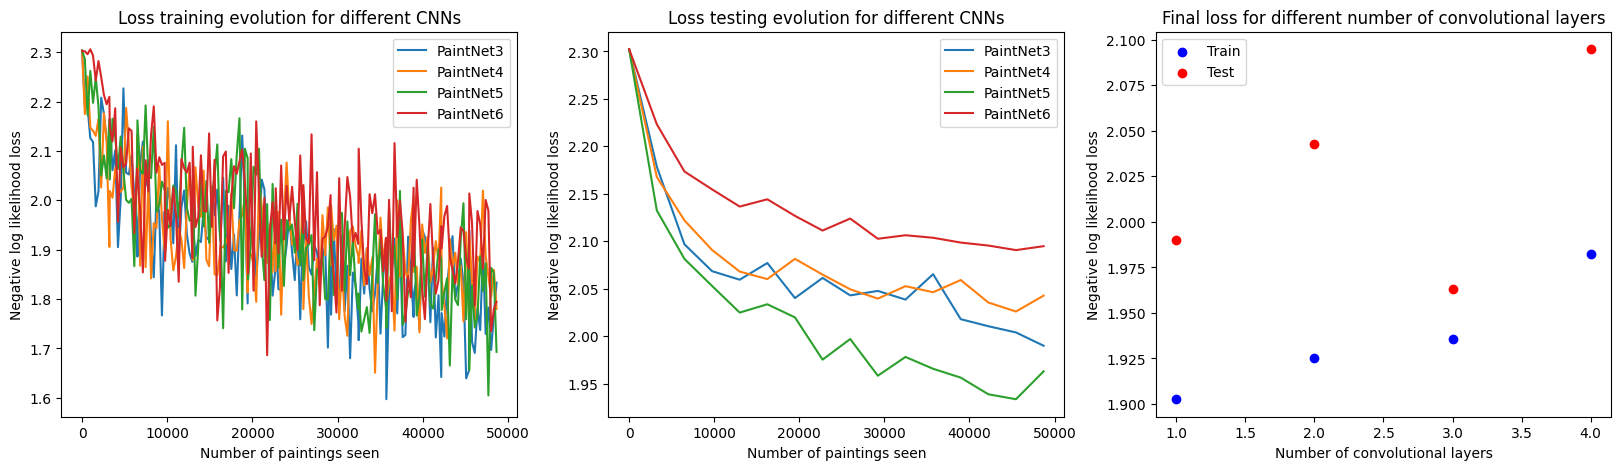

In [63]:
# Plot the average loss rate vs the learning rate, and look for the minimum.

fig, axs = plt.subplots(1,3,figsize=(20,5))
axs[0].plot(train_counter_nw[0],train_loss_nw[0], label='PaintNet3')
axs[0].plot(train_counter_nw[1],train_loss_nw[1], label='PaintNet4')
axs[0].plot(train_counter_nw[2],train_loss_nw[2], label='PaintNet5')
axs[0].plot(train_counter_nw[3],train_loss_nw[3], label='PaintNet6')
axs[0].set_xlabel("Number of paintings seen")
axs[0].set_ylabel("Negative log likelihood loss")
axs[0].set_title("Loss training evolution for different CNNs")
axs[0].legend()

# Create destination directory if it doesn't exist

axs[1].plot(test_counter_nw[0],test_loss_nw[0], label='PaintNet3')
axs[1].plot(test_counter_nw[1],test_loss_nw[1], label='PaintNet4')
axs[1].plot(test_counter_nw[2],test_loss_nw[2], label='PaintNet5')
axs[1].plot(test_counter_nw[3],test_loss_nw[3], label='PaintNet6')
axs[1].set_xlabel("Number of paintings seen")
axs[1].set_ylabel("Negative log likelihood loss")
axs[1].set_title("Loss testing evolution for different CNNs")
axs[1].legend()

axs[2].scatter(range(1,5), np.mean(train_loss_nw_arr[:,-20:],axis=2)[0], color='blue', label='Train') # Average loss at the end
axs[2].scatter(range(1,5), test_loss_nw_arr[0,:,-1], color='red', label='Test') # Average testing loss at the end
axs[2].set_xlabel("Number of convolutional layers")
axs[2].set_ylabel("Negative log likelihood loss")
axs[2].set_title("Final loss for different number of convolutional layers")
axs[2].legend()
plt.show()

In the above plots we can see that the evolutions are kind of similar, although some networks performed better than others. This is espcially visible in the middle and most right plot. We can see here that PaintNet5, so the CNN architecture with 2 linear layers and 3 convolutional layers, performs the best on the test data set. For this reason, we continue the analysis with this particular model.

In [80]:
network_best = networks_output[2] # This is the trained PaintNet5

**Showing the results**

In this subsection, we give and show the results of the best model, in this case PaintNet5. It does so by giving the final accuracy, showing some examples of the predictions, showing the accuracies seperately per painter and showing the confusion matrix.

In [66]:
# Calculate all accuracies

count=0
correct_painters = np.zeros(10)
tot_paintings = np.zeros(10)
pred_list = []
act_list = []
for data, target in test_loader:
    with torch.no_grad():
        output = network_best(data.to(DEVICE))
    for i in range(0, len(target)):
        act = int(target[i])
        act_list.append(int(act))
        pred = int(output.data.max(1, keepdim=True)[1][i][0])
        pred_list.append(int(pred))
        tot_paintings[act] = tot_paintings[act]+1
        if act==pred:
            correct_painters[act] = correct_painters[act]+1
            count=count+1

acc_painters = correct_painters/tot_paintings

In [74]:
# Show the final accuracy
acc_best = np.sum(correct_painters)/np.sum(tot_paintings)
print(f"The best obtained accuracy is {round(acc_best,3)}")

The best obtained accuracy is 0.501


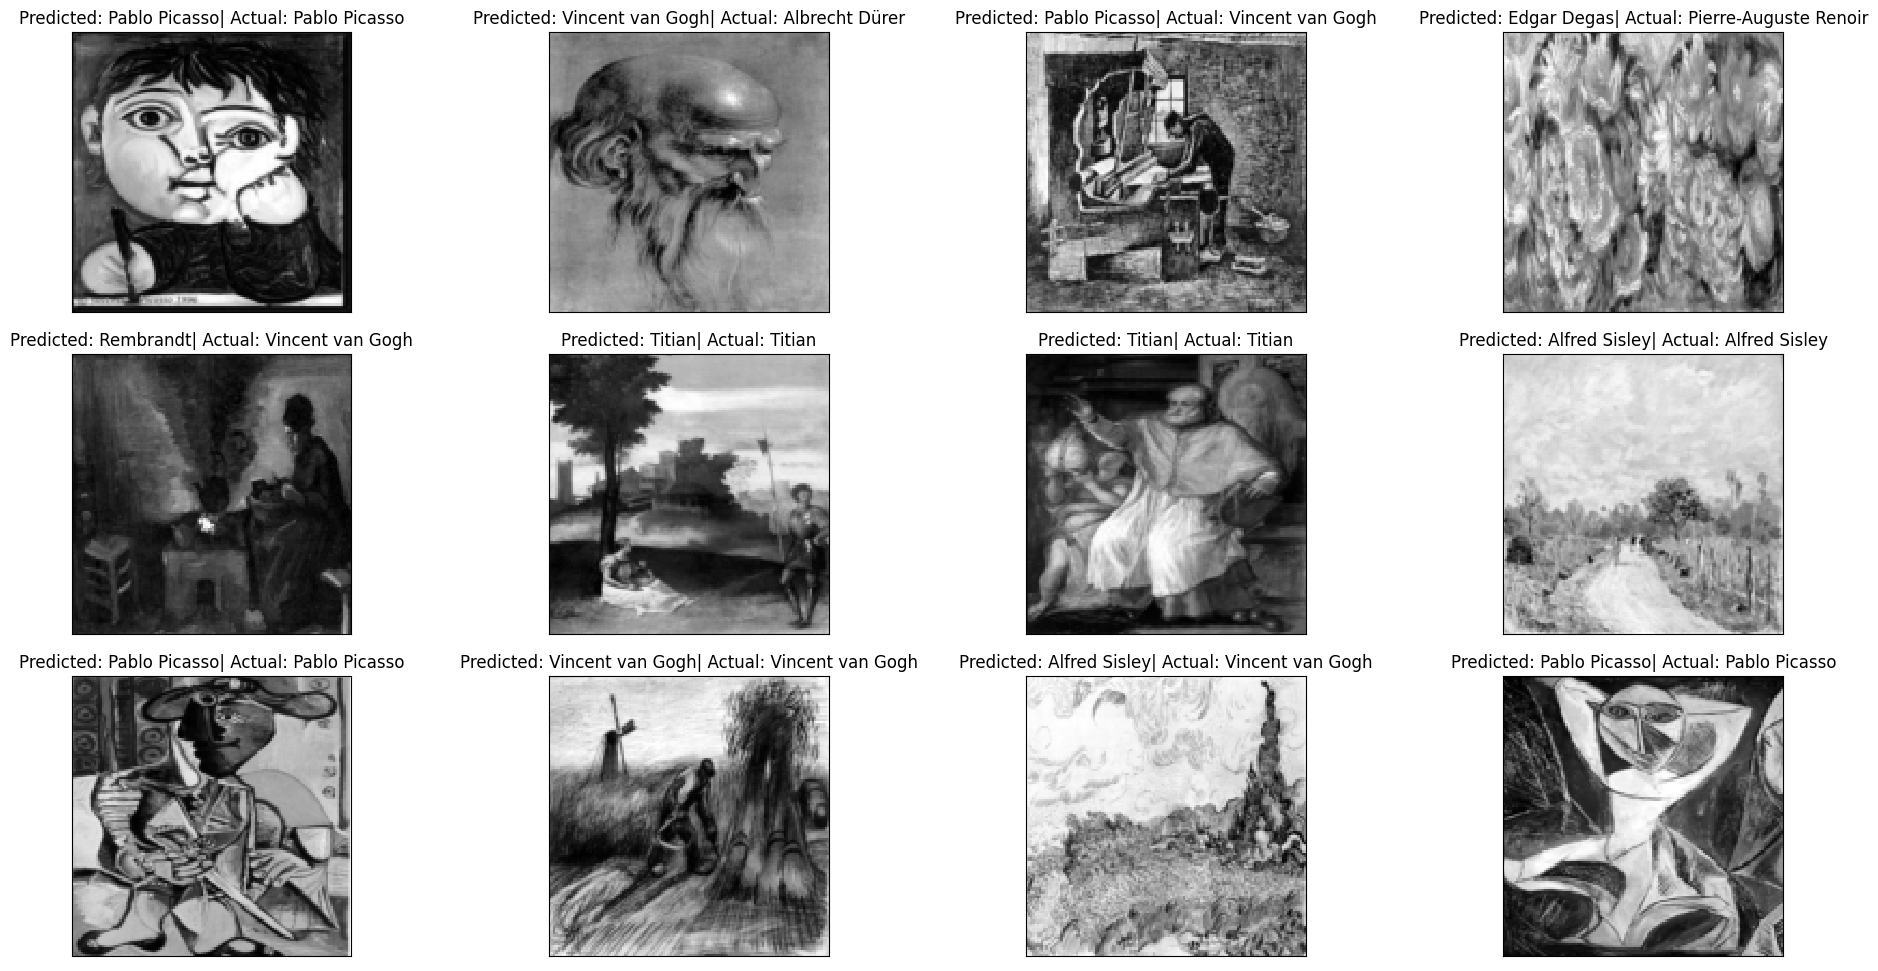

In [75]:
with torch.no_grad():
    output = network_best(example_data.to(DEVICE))

fig = plt.figure(figsize=(20, 10))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    pred = artists_alphabet['name'].iloc[(output.data.max(1, keepdim=True)[1][i].item())]
    target_name = artists_alphabet['name'].iloc[int(example_targets[i])]
    plt.title(f"Predicted: {pred}| Actual: {target_name}")
    plt.xticks([])
    plt.yticks([])

Underneath, we show the accuracy per painter seperately, so that we can see on whom the model performed the best.

Text(0.5, 1.0, 'Accuracy model per painter')

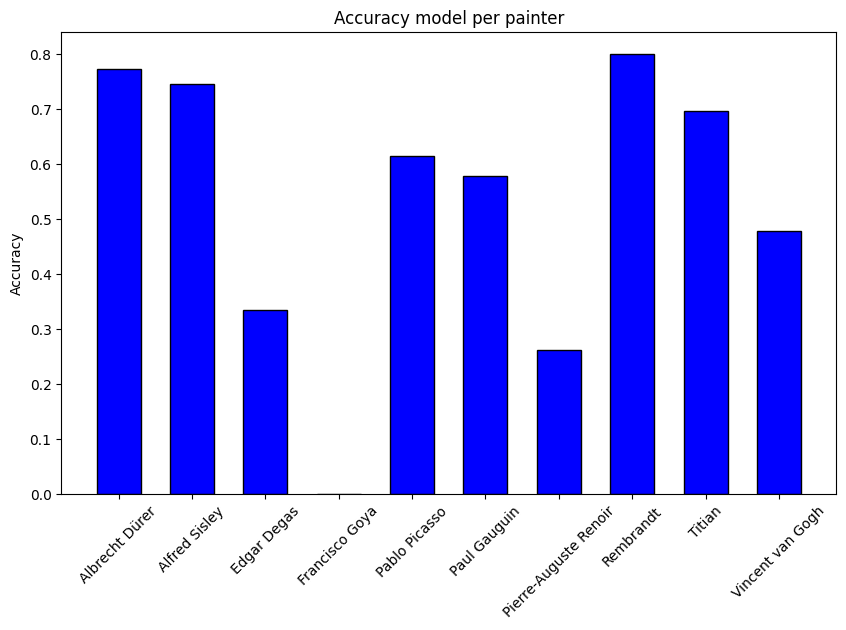

In [77]:
# Plotting with space between bars
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.6  # Width of the bars
bar_positions = range(10)  # Positions for each bar

# Create the bars with a specified width and space between them
ax.bar(bar_positions, acc_painters, width=bar_width, color='blue', edgecolor='black')
ax.set_xticks(bar_positions)
ax.set_xticklabels(artists_alphabet['name'], rotation=45)  # Rotate painter names for better readability
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy model per painter")

Finally, we create a confusion matrix, to see what happens when a painting is classified to the wrong painter.

In [78]:
cm = confusion_matrix(act_list, pred_list, labels=range(10), normalize='true')

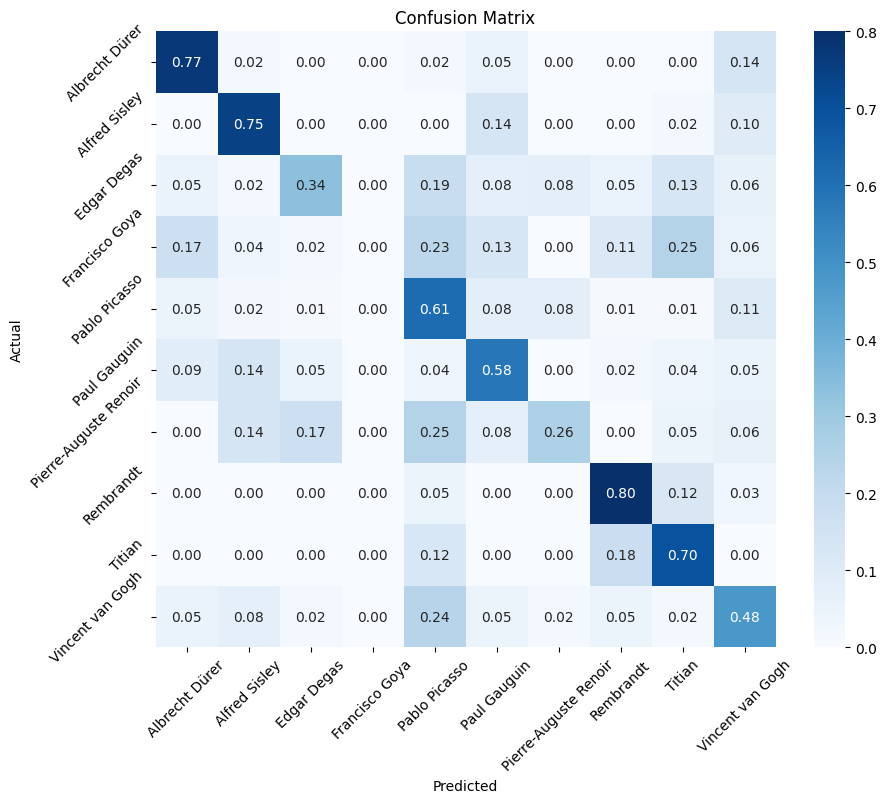

In [79]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=artists_alphabet['name'], yticklabels=artists_alphabet['name'])

# Labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

## 5. Discussion

**Choice of model and parameters**

From the learning rate plots, we observe that learning rates equal or greater than $10^{-3}$ failed to adequately capture the data. On the other end, a learning rate of $10^{-5}$ was too slow, resulting in suboptimal loss. We can see that the learning rate of $10^{-4}$ emerged as the optimal parameter value for this particular analysis.
<br> <br>
In this analysis, we experimented with 4 different CNN architectures, varying only in the number of convolutional layers. Interestingly, we see that the PaintNet3 model was already very capable of classifying compared to the other architectures. This suggests that the increase in complexity does barely enhance the model performance. Conversely, PaintNet6, the most complex model of the set, converged to the highest loss. A reason might be that the random initialization of these parameters could have resulted in a longer convergence time to optimal values. Interestingly, the peformance did not consistently correlate with the models complexity. This might also be a sign of a significant impact of random intialization. By training the same model multiple times, this effect might be studied further.

**Performance and shortcomings**

We analyzed 10 painters and created a dataset with an equal amount of paintings per painter. This setup indicates a baseline performance of 10%. However, if the model would only guess a painting to be from Vincent van Gogh, it would score an accuracy of 22%, acting as our true baseline. The final accuracy of the best trained model was 50%. Therefore, we can conclude that the model did learn significanly from the data. Nonetheless, the fact that it still mispredicts the painting once every two times strongly limits its practical usefulness in real-life applications.

An accuracy of 0.5 aligns well with literature for similar models. For example, another CNN with 4 layers ended with an accuracy of 42%, although it classified more painters [6]. Literature shows more examples of accuracies that obtain a maximum accuracy of ~50% for CNNs built from scratch [7][8].

The biggest increase in capbilities of these methods come from the method of transfer learning. This is a machine learning technique where a pre-trained model is used and is finetuned for your specific task. In this context, very deep models (dozens of layers) that are already trained on general image data can be used. These pre-trained models, that already recognize numerous features in images, can be adapted and finetuned for classifying paintings. Previous literature has shown that a transfer learned model like ResNet18 can achieve an accuracy of approximately 80%, while Xception can reach up to 95% [6][9]. We conclude that transfer learning is currently the most promising method in classifying artists.

**Mispredictions of the model**

In this final subsection, we examine somemispredictions made by the best CNN by comparing the actual painter with the predicted painter and speculate on potential shortcomings of the model. One challenge might be distinguishing between similar painting styles. It would not be surprising if the model mispredicts painters who worked within the same genre, since the model relies on recognizing stylistic elements.

For example, many paintings from Alfred Sisley were misidentified as Paul Gauguin's and vice versa. This can be explained by the fact that Sisley painted in the impressionist style, while Gauguin also started out as an impressionist [10]. Similarly, this problem occured between Rembrandt and Titian. Although Rembrandt painted in the baroque style and Titian in the high renaissance style, art historians agree that many Rembrandts were greatly influenced by the work of Titian [11]. This highlights the model's struggle of identifying paintings from similar artists.

However, reasons behind some mispredicitons are harder to identify. Firstly, Fransisco Goya's paintings were never correctly classified, but were assigned to painters from various styles. Additionally, a lot of paintings were mistaken to be from Pablo Picasso. To gain insights on these less obvious mistakes, it could be beneficial to use model interpretation techniques. These could point at the elements on which the model focuses and potentially provide an explanation for some of the mispredictions. Furthermore, this could be used to our advantage and lead to an improvement of the model.

## 6. Conclusion

**Summary and findings**

We aimed at solving an art classification problem by creating a model that can predict which painting belong to which painter. This task was performed on 10 famous painters, each having created more than 250 paintings, using a dataset from Kaggle. All paintings were normalized, and the dataset was balanced to ensure that the model learns. We found that a learning rate of $10^{-4}$ was optimal for this task. Furthermore, we trained four different CNN architectures, varying the range of convolutional layers from 1 to 4. The model with 3 convolutional layers performed the best, though we acknowledge that this might be influenced by the random initialization of the model parameters. Our best model achieved a final accuracy of 50%, which aligns well with literature from similar models, although pre-trained models have achieved significantly better results. Finally, we observed that some of the mispredictions might be explained by painters who worked in similar styles, although some of the mispredictions were harder to identify.

**Future research**

The work done in this study is very relevant for the future. It could help art historians understand which components of paintings are essential to the style of certain artists. Furthermore, as models continue to improve, they could eventually assist art historians in identifying authentic paintings from forgeries. The final model is still far from useful for real-life application, but do observe some potential improvements and future research possibilities.

Firstly, the learning rate could be improved by using an adaptive learning rate instead of a constant one, potentially helping the model converge to a more optimal accuracy. Secondly, a major limitation in art classification is the number of paintings available per painter, which restricts our training data. To create more data and keep the model from overfitting, one could experiment with data augmentation. One safe improvement is horizontal flipping, keeping the symmetry in the paintings. Additionally, experimenting with other augmentation techqniques, such as rotating, could be useful, though one has to be careful for loosing critical style elements. Thirdly, a potential improvement might be the use of deeper models. Our relatively simple models are limited to detecting more basic style elements, such as light-dark contrasts. Deeper models might recognize more detailed style elements, something that could help distuinguish between painters within similar styles. Finally, literature indicates that the greatest improvement comes from transfer learning. By using pre-trained models, built ourselves or like those from ImageNet, we could achieve a significant improvement in accuracy.

## References

[1] Yadav, Nitin. Redefining Intelligence: The Deep Learning Revolution in AI. (2024). <br>
[2] Sarker, I.H. Deep Learning: A Comprehensive Overview on Techniques, Taxonomy, Applications and Research Directions. SN COMPUT. SCI. 2, 420 (2021). <br>
[3] L. A. Gatys, A. S. Ecker, and M. Bethge. A neural algorithm of artistic style. CoRR, abs/1508.06576, (2015). <br>
[4] Polatkan, G., Jafarpour, S., Brasoveanu, A., Hughes, S., & Daubechies, I. (2009, November). Detection of forgery in paintings using supervised learning. In Image Processing (ICIP), 2009 16th IEEE International Conference on (pp. 2921-2924). IEEE. <br>
[5] Kaggle. https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time <br>
[6] Nitin Viswanathan. Artist Identification with Convolutional Neural Networks. <br>
[7] B. Saleh, A. Elgammal. Large-scale Classification of Fine-Art Paintings: Learning The Right Metric on The Right Feature. (2015). <br>
[8] B. Howell. Using Convolutional Neural Networks to Predict Completion Year of Fine Art Paintings <br>
[9] R. S. Teles de Menezes, Angelo M. Cordeiro, R. M. Magalhães, H. Maia. Classification of Paintings Authorship Using Convolutional Neural Network. (2021). <br>
[10] M. Schapiro. Impressionism: Reflections and Perceptions. (1997). <br>
[11]. G. Baldwin Brown. Rembrandt: A study of his life and work. (1907).

## AI Usage

ChatGPT was used for helping some of the coding and was used helping writing. The writing was never completely copied, but only used as inspiration. A few examples tasks were ChaptGPT was used for: It helped me with the method of the random sampler and calculating the weights. It helped me create the confusing matrix and plot it in a pleasing way. For the rest it mostly helped me debug mistakes in the code, and was very limited in creativeness for increasing the model's capibilities.